# Predictive control and denoising

This script implements the spatiotemporal priors for predictive control and reconstruction in Fried Geometry.


Let's first import the libraries and upload the MATLAB-generated system matrix.

The matrix G is the system matrix, i.e.,

$w = G\phi$

and the "mask" is the map of active pixels in a 2D grid.

In [1]:
from hcipy import *
from stgp_util import *
import h5py

import numpy as np
import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt

import scipy.ndimage as ndimage
import scipy
import time
import os

filepath = '8x8_SHS_matrices.mat'
arrays = {}
f = h5py.File(filepath,'r')
for k, v in f.items():
    arrays[k] = np.array(v)

G = arrays["G_fried"]
G = G.transpose()  
   
mask_fried = arrays["mask_fried"]


Next, let us define the telescope, the number of lenslets, the signal-to-noise ratio, the reconstruction grid (according to the Fried geometry), the atmosphere, and the NGS wavelength. We also set the number of past WFS measurements and the number of frames we want to predict.


In [2]:
# telescope
telescope_diameter = 1.6
n_lenslet          = 8
n_pixels           = n_lenslet + 1

# atmosphere
r0             = 0.168 # m
L0             = 20 # meter
Cn2            = np.array([0.5, 0.3, 0.2])
avg_wind       = 15
framerate      = 0.002
winds          = np.array([[framerate*(avg_wind),1e-5],[1e-5,framerate*(avg_wind)],[framerate*avg_wind/1.413,framerate*avg_wind/1.41]])  
wavelength_wfs = 0.7e-6 

# model
n_history = 20 # data steps
n_predict = 2 # predective steps
timesteps = n_history + n_predict
signal_to_noise = 20

Later, we want to visualize the phase and reconstruction, so we construct valid pixel maps to go from vector to image and vice versa.

In [3]:
fried_grid = make_pupil_grid(n_pixels, telescope_diameter + telescope_diameter/(n_pixels -1))

(xvalid, yvalid) = np.nonzero(mask_fried)
mask_st          = np.tile(mask_fried, (timesteps, 1, 1))
(tvalid, x2valid, y2valid) = np.nonzero(mask_st) 

vecvalid          = np.nonzero(mask_fried.flatten())[0]
vecvalid_temporal = np.nonzero(mask_st.flatten())[0]

vec_to_im    = vec_to_img(n_pixels, xvalid, yvalid)
vec_to_im_st = vec_to_img_st(n_pixels, timesteps, tvalid, x2valid, y2valid)
im_to_vec    = img_to_vec(xvalid, yvalid)


# numeber of active pixels
act_pix    = vecvalid.shape[0]
act_pix_st = vecvalid_temporal.shape[0]

## Spatiotemporal GP prediction 

First, we construct the S-GP, FF-GP and WAFF-GP priors: 

$(C_{\rm s})_{ij} = k_{\phi}((x_i, y_i), (x_j, y_j))$,   

$(C_{\rm ff})_{ij} = k_{\Psi_{\rm FF}}((x_i, y_i, t_i), (x_j, y_j, t_j))$, and  

$(C_{\rm waff})_{ij} = k_{\Psi_{\rm WaFF}}((x_i, y_i, t_i), (x_j, y_j, t_j))$,

where $i,j \in \{1, 2, \cdots, \rm nhistory\}$ for $x$ and $y$, and $i,j \in \{1,2, \cdots, \rm timesteps\}$ for $t$ 



In [4]:
n_int = 50 # integration points of WAFF model

Cs        = s_gp(fried_grid, r0, L0)
Cff       = st_gp_ff(timesteps, Cn2, winds, Cs, fried_grid, r0, L0)
Cwaff     = st_gp_waff(timesteps, n_int, framerate*avg_wind, Cs, fried_grid, r0, L0)

In [5]:
# we remove the non-active pixels from the priors
Cs    = Cs[vecvalid,:][:,vecvalid]
Cff   = Cff[vecvalid_temporal,:][:,vecvalid_temporal]
Cwaff = Cwaff[vecvalid_temporal,:][:,vecvalid_temporal]

We draw a sample $\Phi$ from the $C_{\rm waff}$ prior by multiplying the Cholesky factor with white noise. 

<IPython.core.display.Javascript object>


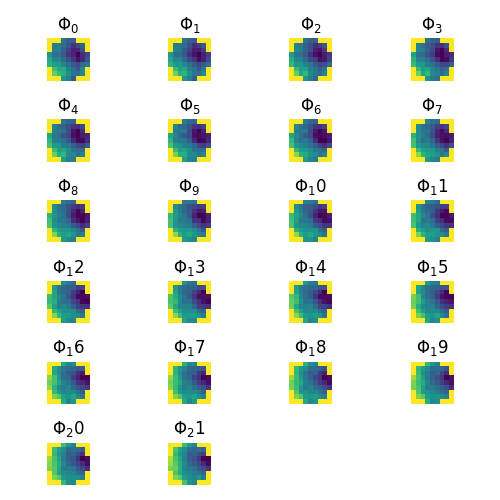

In [6]:
Chol_ff = np.linalg.cholesky(Cff + 1e-8*np.diag(np.random.randn(timesteps*(act_pix))**2))

Phi     = np.matmul(Chol_ff, np.random.normal(0,1,timesteps*(act_pix)))
Phi_img = np.zeros((n_history + n_predict, n_pixels, n_pixels))

# reshape 
for i in range(timesteps):
    Phi_img[i,:,:] = vec_to_im(Phi[0 + i*act_pix:act_pix + i*act_pix])

# Create a figure to display the images
fig, axes = plt.subplots(int(np.ceil(timesteps/4)), 4, figsize=(5, 5))  # Adjust figsize as needed

# Plot each image in the stack
for i in range(int(np.ceil(timesteps/4))):
    for j in range(4):      
        if i*4 + j < timesteps:
            axes[i][j].imshow(Phi_img[i*4 + j,:, :])  # You can change the cmap if needed
            axes[i][j].set_title(f'$\Phi_{i*4+j}$')
        axes[i][j].axis('off')  # Turn off axis labels
           

# Show the plot
plt.tight_layout()
plt.show()


Next, we compute the signal strength in WFS measurement and adjust the measurement noise w.r.t. S/N given.

In [7]:
signal_variance = G @ Cs @ G.transpose()
signal_strength = np.mean(np.diag(signal_variance))

noise_to_signal = 1/signal_to_noise
noise_var = (noise_to_signal**2) * signal_strength

The following shell constructs the spatiotemporal system matrix A and calculate the data set "slopes".

In [8]:
A          = scipy.linalg.block_diag(*([G] * n_history))
A          = np.concatenate((A, np.zeros((A.shape[0], n_predict * G.shape[1]))),1)
  
slopes = A @ Phi + np.sqrt(noise_var)*np.random.normal(0,1,A.shape[0]) 
slopes = np.reshape(slopes,(n_history,G.shape[0])) 

By the Bayes' formula, the Gaussian prior models combined with the Gaussian likelihood yield a Gaussian posterior defined by the covariance matrix:

$C_{\rm post} = \left(A^\top C_{\rm noise}^{-1}A + C_{\rm prior}^{-1}\right)^{-1}$

and the mean vector

$ \Phi_{\rm post} = C_{\rm post} A^\top C_{\rm noise}^{-1}  W$.

The recontruction matrices $R_{FF}$, $R_{WAFF}$ and $R_{s}$ for the whole time sequence are given then by

$R_{\rm FF/WAFF/s} = C_{\rm post} A^\top C_{\rm noise}^{-1}$




In [9]:
Cff_inv    = np.linalg.inv(Cff)
Cwaff_inv  = np.linalg.inv(Cwaff)
Cs_inv     = np.linalg.inv(Cs)

Cff_post   =  np.linalg.inv(A.transpose() @ ((1/noise_var)*np.eye(A.shape[0])) @ A  +  Cff_inv)
Cwaff_post =  np.linalg.inv(A.transpose() @ ((1/noise_var)*np.eye(A.shape[0])) @ A  +  Cwaff_inv)
Cs_post    =  np.linalg.inv(G.transpose() @ ((1/noise_var)*np.eye(G.shape[0])) @ G  +  Cs_inv)  

Rff   = Cff_post @ A.transpose() @ ((1/noise_var)*np.eye(A.shape[0]))
Rwaff = Cwaff_post @ A.transpose() @ ((1/noise_var)*np.eye(A.shape[0]))
Rs    = Cs_post @ G.transpose() @ ((1/noise_var)*np.eye(G.shape[0]))

Next, we solve for the mean vectors $\mu_{\rm FF}, \mu_{\rm WAFF}$ and  $\mu_{\rm s}$

In [10]:
mu_ff   = Rff   @ slopes.flatten('C')
mu_waff = Rwaff @ slopes.flatten('C')

# solve mean vector mu_s for each timestep separately. Last frame is repeated for future frames (no prediction).
mu_s = np.zeros((timesteps, vecvalid.shape[0]))
for i in range(timesteps):
    mu_s[i,:] = Rs @ slopes[min(i,n_history-1),:] 
    
mu_s = mu_s.flatten('C')    

Now, we have the posterior distributions for each method.
Let us examine the S-GP posterior variance $C_{\rm post, s}$ by taking singular value decomposition (SVD). 

The first eigenvector corresponds to piston mode. The majority of the uncertainty is located in this mode.

<IPython.core.display.Javascript object>


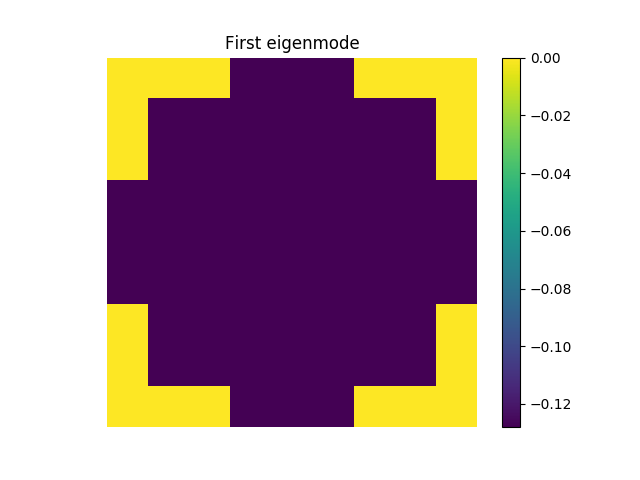

In [11]:
u, s, vh = np.linalg.svd(Cs_post, full_matrices=True)

# visualize the first eigen vector of C
plt.imshow(vec_to_im(u[:,0])) 
plt.axis('off')
plt.colorbar()
plt.title('First eigenmode')
plt.show()


As the piston does not affect the AO performance, we filter the piston from the covariance matrix, mean vector, and the ground truth $\phi$ for each timestep separately. 

In [12]:
u_crop      = u.copy()
u_crop[:,0] = 0

Cs_np   = u_crop @ u.transpose() @ Cs_post

Cff_np = np.zeros(Cff.shape)
Cwaff_np = np.zeros(Cwaff.shape)

mu_s_np = np.zeros(mu_ff.shape)
mu_ff_np = np.zeros(mu_ff.shape)
mu_waff_np = np.zeros(mu_waff.shape)

Phi_np = np.zeros(Phi.shape)

for i in range(timesteps):
    Cff_np[i*act_pix:act_pix + i*act_pix,i*act_pix:act_pix + i*act_pix]   = u_crop @ u.transpose() @ Cff_post[i*act_pix:act_pix + i*act_pix,i*act_pix:act_pix + i*act_pix] 
    Cwaff_np[i*act_pix:act_pix + i*act_pix,i*act_pix:act_pix + i*act_pix] = u_crop @ u.transpose() @ Cwaff_post[i*act_pix:act_pix + i*act_pix,i*act_pix:act_pix + i*act_pix] 

    mu_s_np[i*act_pix:act_pix + i*act_pix]    = u_crop @ u.transpose() @ mu_waff[i*act_pix:act_pix + i*act_pix] 
    mu_ff_np[i*act_pix:act_pix + i*act_pix]   = u_crop @ u.transpose() @ mu_ff[i*act_pix:act_pix + i*act_pix] 
    mu_waff_np[i*act_pix:act_pix + i*act_pix] = u_crop @ u.transpose() @ mu_waff[i*act_pix:act_pix + i*act_pix] 

    Phi_np[i*act_pix:act_pix + i*act_pix] = u_crop @ u.transpose() @ Phi[i*act_pix:act_pix + i*act_pix] 
        
Phi_img_np = vec_to_im_st(Phi_np)        

## Visualization of the results

Let us next visualize the results. We start by converting the mean vectors and $C_{\rm post}$ diagonal elements (posterior variance) to 3D tensors (t,x,y). We also add the temporal variance to the S-GP posterior:

$\sigma_{\rm temp } = \text{Var}(\phi(x,y,t_1) - \phi(x,y,t_2)) = 2k_\psi(0) - 2 k_\psi((x,y,t_1), (x,y,t_2))$

In [13]:
mu_ff_img   = vec_to_im_st(mu_ff_np)
mu_waff_img = vec_to_im_st(mu_waff_np)
mu_s_img    = vec_to_im_st(mu_s_np)

var_ff_img   = vec_to_im_st(np.diagonal(Cff_np))
var_waff_img = vec_to_im_st(np.diagonal(Cwaff_np))
var_s_img    = np.zeros((timesteps,n_pixels,n_pixels))

for i in range(n_history):
    var_s_img[i,:,:] = vec_to_im(np.diagonal(Cs_np))

# add temporal variance for S-GP    
for i in range(n_predict):
    var_s_img[n_history + i,:,:] = vec_to_im(np.diagonal(Cs_np) + 2*Cff[0,0] - 2*Cff[(i+1)*act_pix,0])

We plot the mean vectors for $\phi_{p+2}$

<IPython.core.display.Javascript object>


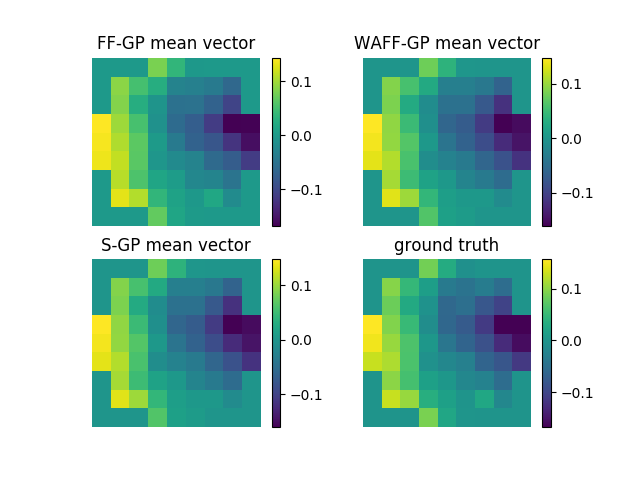

In [14]:
constant = ((wavelength_wfs / (2 * np.pi)) * 1e6)**2

fig, axs = plt.subplots(2,2)
im1 = axs[0][0].imshow(mu_ff_img[-1,:,:]*constant)
plt.colorbar(im1, ax=axs[0][0])
axs[0][0].axis(False)
axs[0][0].set_title('FF-GP mean vector')

im3 = axs[0][1].imshow(mu_waff_img[-1,:,:]*constant)
plt.colorbar(im3, ax=axs[0][1])
axs[0][1].axis(False)
axs[0][1].set_title('WAFF-GP mean vector')

im2 = axs[1][0].imshow(mu_s_img[-1,:,:]*constant)
plt.colorbar(im2, ax=axs[1][0])
axs[1][0].axis(False)
axs[1][0].set_title('S-GP mean vector')

im4 = axs[1][1].imshow(Phi_img_np[-1,:,:]*constant)
plt.colorbar(im4, ax=axs[1][1])
axs[1][1].axis(False)
axs[1][1].set_title('ground truth')


plt.show()



Next, we plot the variance (diagonal of posterior covariance) of $\phi_{p+2}$, which measures the reconstruction accuracy.

<IPython.core.display.Javascript object>


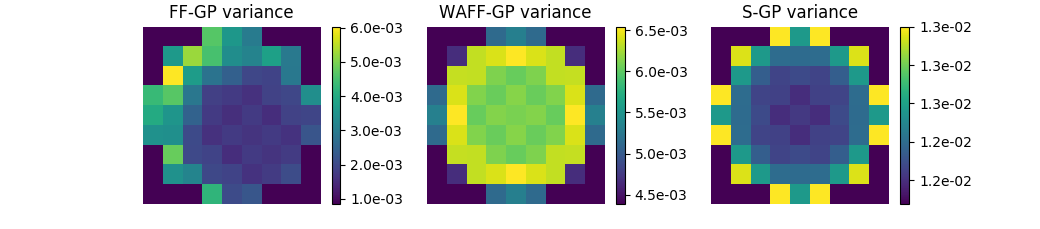

In [15]:
constant = ((wavelength_wfs / (2 * np.pi)) * 1e6)**2

ff_max = np.amax(var_ff_img[-1,:,:]*constant)
ff_min = np.amin(var_ff_img[-1,:,:]*constant, where=var_waff_img[-1,:,:]!=0, initial=2)
waff_max = np.amax(var_waff_img[-1,:,:]*constant)
waff_min = np.amin(var_waff_img[-1,:,:]*constant, where=var_waff_img[-1,:,:]!=0, initial=2)
s_max = np.amax(var_s_img[-1,:,:]*constant)
s_min = np.amin(var_s_img[-1,:,:]*constant, where=var_s_img[-1,:,:]!=0, initial=2)

fig, axs = plt.subplots(1,3,figsize = (10.4,2.3))
im1 = axs[0].imshow(var_ff_img[-1,:,:]*constant, vmin=ff_min- 0.15*abs(ff_min-ff_max), vmax=ff_max)
plt.colorbar(im1, ax=axs[0], format='%.1e')
axs[0].axis(False)
axs[0].set_title('FF-GP variance')

im3 = axs[1].imshow(var_waff_img[-1,:,:]*constant, vmin=waff_min- 0.15*(abs(waff_min-waff_max)), vmax=waff_max)
plt.colorbar(im3, ax=axs[1], format='%.1e')
axs[1].axis(False)
axs[1].set_title('WAFF-GP variance')

im2 = axs[2].imshow(var_s_img[-1,:,:]*constant, vmin=s_min- 0.15*(abs(s_min-s_max)), vmax=s_max)
plt.colorbar(im2, ax=axs[2], format='%.1e')
axs[2].axis(False)
axs[2].set_title('S-GP variance')


plt.show()

We then compare the variance of the spatiotemporal models, FF-GP and WAFF-GP, to the non-predictive S-GP.

<IPython.core.display.Javascript object>


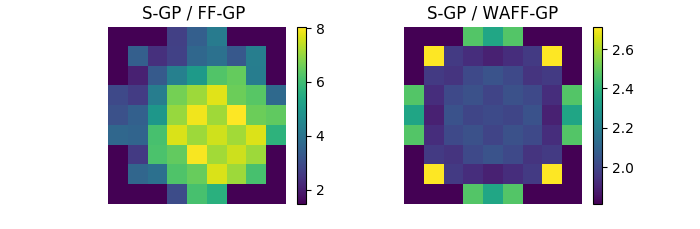

In [16]:
fig, axs = plt.subplots(1,2,figsize = (7,2.3))

gain_ff = np.divide(var_s_img[-1,:,:], var_ff_img[-1,:,:], out=np.zeros_like(var_s_img[-1,:,:]), where=var_ff_img[-1,:,:]!=0)
gain_waff = np.divide(var_s_img[-1,:,:], var_waff_img[-1,:,:], out=np.zeros_like(var_s_img[-1,:,:]), where=var_waff_img[-1,:,:]!=0)


gain_max = np.amax(gain_ff)
gain_min = np.amin(gain_ff, where=var_ff_img[-1,:,:]!=0, initial=10)
gain_max2 = np.amax(gain_waff)
gain_min2 = np.amin(gain_waff, where=var_waff_img[-1,:,:]!=0, initial=10)

im4 = axs[0].imshow(gain_ff, vmin=gain_min - 0.1*abs(gain_min-gain_max), vmax=gain_max)
plt.colorbar(im4, ax=axs[0])
axs[0].axis(False)
axs[0].set_title('S-GP / FF-GP ')

im4 = axs[1].imshow(gain_waff, vmin=gain_min2 - 0.1*abs(gain_min2-gain_max2), vmax=gain_max2)
plt.colorbar(im4, ax=axs[1])
axs[1].axis(False)
axs[1].set_title('S-GP / WAFF-GP')
plt.show()

Next, we plot a temporal slice from the reconstruction of the whole time series $\Phi_{\rm post}$. We plot the mean value on each time step along the $95$ % confidence interval calculated from the posterior covariance matrix.

<IPython.core.display.Javascript object>


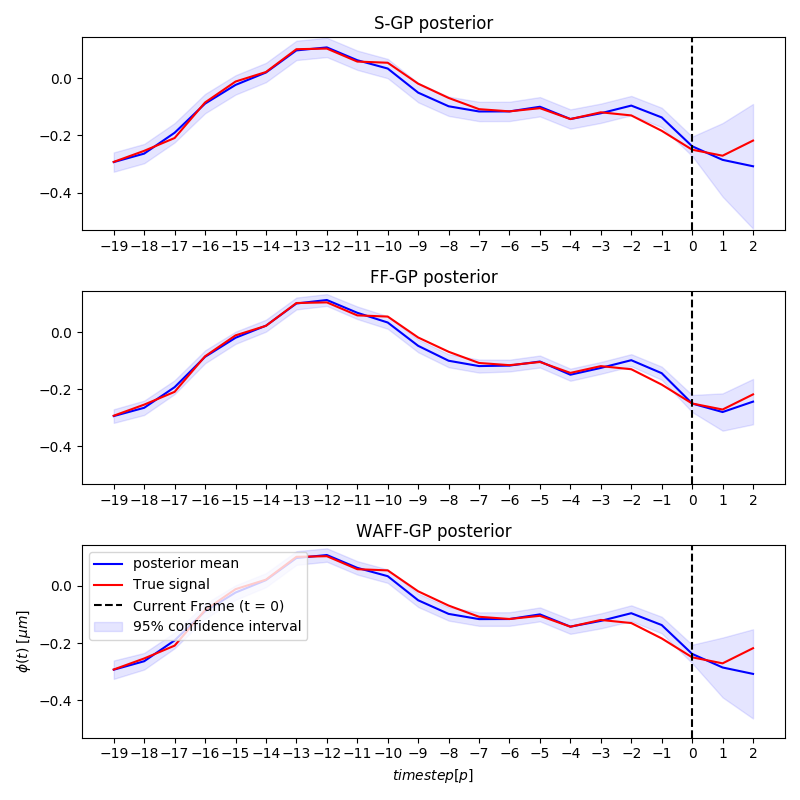

In [17]:
# Plot temporal behaviour on single reconstruction point in the grid
xx = 6
yy = 6
t_axis = np.linspace(0, (timesteps-1), timesteps).reshape(timesteps,1) - (n_history-1)

ff_mu    = mu_ff_img[:,xx,yy]
ff_var   = var_ff_img[:,xx,yy]

waff_mu  = mu_waff_img[:,xx,yy]
waff_var = var_waff_img[:,xx,yy]

s_mu     = mu_s_img[:,xx,yy]
s_var    = var_s_img[:,xx,yy]

upper_bound_SGP = (s_mu.reshape(n_history + n_predict,) + 1.96 * np.sqrt(s_var.squeeze()))*(wavelength_wfs / (2 * np.pi)) * 1e6
lower_bound_SGP = (s_mu.reshape(n_history + n_predict,) - 1.96 * np.sqrt(s_var.squeeze()))*(wavelength_wfs / (2 * np.pi)) * 1e6

upper_bound = (ff_mu.reshape(n_history + n_predict,) + 1.96 * np.sqrt(ff_var.squeeze()))* (wavelength_wfs / (2 * np.pi)) * 1e6     
lower_bound = (ff_mu.reshape(n_history + n_predict,) - 1.96 * np.sqrt(ff_var.squeeze()))* (wavelength_wfs / (2 * np.pi)) * 1e6     

upper_bound_iso = (waff_mu.reshape(n_history + n_predict,) + 1.96 * np.sqrt(waff_var.squeeze()))* (wavelength_wfs / (2 * np.pi)) * 1e6     
lower_bound_iso = (waff_mu.reshape(n_history + n_predict,) - 1.96 * np.sqrt(waff_var.squeeze()))* (wavelength_wfs / (2 * np.pi)) * 1e6     

SGP_max = np.amax(upper_bound_SGP)
SGP_min = np.min(lower_bound_SGP)


# Create a figure with two subplots
fig, axs = plt.subplots(3, 1, figsize=(8, 8))

# First subplot
axs[0].plot(t_axis, s_mu * (wavelength_wfs / (2 * np.pi)) * 1e6, 'b-', label='posterior mean')
axs[0].plot(t_axis, Phi_img_np[:, xx, yy]* (wavelength_wfs / (2 * np.pi)) * 1e6, 'r-', label='True signal')
axs[0].fill_between(t_axis.ravel(), lower_bound_SGP, upper_bound_SGP, color='b', alpha=0.1, label='95% confidence interval')
axs[0].axvline(x=0.0, color='black', linestyle='--', label='Current Frame (t = 0)')
#axs[0].set_ylabel('$\phi(t) \ [\mu m]$')
axs[0].set_xticks(t_axis)
axs[0].set_ylim(SGP_min - abs(0.01 * SGP_min), SGP_max + abs(0.01 * SGP_max))
#axs[0].legend(loc='upper left')
axs[0].set_title('S-GP posterior')

# Second subplot
axs[1].plot(t_axis, ff_mu * (wavelength_wfs / (2 * np.pi)) * 1e6, 'b-', label='posterior mean')
axs[1].plot(t_axis, Phi_img_np[:, xx, yy] * (wavelength_wfs / (2 * np.pi)) * 1e6, 'r-', label='True signal')
axs[1].fill_between(t_axis.ravel(), lower_bound, upper_bound, color='b', alpha=0.1, label='95% confidence interval')
axs[1].axvline(x=0.0, color='black', linestyle='--', label='Current Frame (t = 0)')
#axs[1].set_ylabel('$\phi(t) \ [\mu m]$')
axs[1].set_xticks(t_axis)
axs[1].set_ylim(SGP_min - abs(0.01 * SGP_min), SGP_max + abs(0.01 * SGP_max))
#axs[1].legend(loc='upper left')
axs[1].set_title('FF-GP posterior')



# Second subplot
axs[2].plot(t_axis, waff_mu * (wavelength_wfs / (2 * np.pi)) * 1e6, 'b-', label='posterior mean')
axs[2].plot(t_axis, Phi_img_np[:, xx, yy] * (wavelength_wfs / (2 * np.pi)) * 1e6, 'r-', label='True signal')
axs[2].fill_between(t_axis.ravel(), lower_bound_iso, upper_bound_iso, color='b', alpha=0.1, label='95% confidence interval')
axs[2].axvline(x=0.0, color='black', linestyle='--', label='Current Frame (t = 0)')
axs[2].set_xlabel('$time step [p]$')
axs[2].set_ylabel('$\phi(t) \ [\mu m]$')
axs[2].set_xticks(t_axis)
axs[2].set_ylim(SGP_min - abs(0.01 * SGP_min), SGP_max + abs(0.01 * SGP_max))
axs[2].legend(loc='upper left')
axs[2].set_title('WAFF-GP posterior')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()